In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import numpy as np
import torch.optim as optim
from matplotlib import pyplot as plt

In [2]:
import numpy as np
import utils
import torch 
from torch.autograd import Variable
from Modules import VAE
import torch.nn as nn
import torch.nn.functional as F

filename = "/home/wafa/Desktop/study/sketchRNN/aaron_sheep.npz"
load_data = np.load(filename, encoding = 'latin1')
train_set = load_data['train'][:200]
test_set = load_data['test'][:100]

nb_steps = 100
feature_len=5
batch_size = 100
max_seq_len=250

train_set = utils.DataLoader(train_set, batch_size)
test_set = utils.DataLoader(test_set, batch_size)

total images <= max_seq_len is 200
total images <= max_seq_len is 100


In [3]:
class Decoder(nn.Module):
    
    def __init__(self, strokeSize, batchSize,  Nhe, Nhd, Nz, Ny):
        super(Decoder, self).__init__()
        self.Nhe = Nhe
        self.Nhd = Nhd
        self.cell = nn.LSTM(strokeSize, Nhd, 1, batch_first=True)
        self.y = nn.Linear(Nhd, Ny)
    
    def forward(self, x):
        output, (hn, cn) = self.cell(x)
        #print("avant reshape", output.size())
        #print(output.contiguous().view(-1, self.Nh).size())
        output = output.contiguous().view(-1, self.Nhd)
        #print("after", output.size())
        y = self.y(output)
        return y  

In [4]:
class SketchRNN(nn.Module):
    
    def __init__(self, strokeSize, batchSize, Nhe, Nhd, Nz, Ny, max_seq_len):
        super(SketchRNN, self).__init__()
        self.batchSize = batchSize
        self.Nhe = Nhe
        self.Nhd = Nhd
        self.max_seq_len = max_seq_len
        self.Nz = Nz
        self.decoder = Decoder(strokeSize, batchSize, Nhe, Nhd, Nz, Ny)
        
    def forward(self, x):
        #here we take S0
        y = self.decoder(x[:, :250, :])
        return y


In [5]:
class Loss():  
    
    def bi_normal(self, x1, x2, mu1, mu2, s1, s2, rho):

        x1 = x1.contiguous().view(-1, 1).expand(x1.size(0), M)
        x2 = x2.contiguous().view(-1, 1).expand(x2.size(0), M)
        norm1 = x1 - mu1
        norm2 = x2 - mu2
        z = torch.div(norm1, s1).pow(2) + torch.div(norm2, s2).pow(2) - 2 * torch.div(torch.mul(rho, torch.mul(norm1, norm2)), torch.mul(s1,s2))
        coef = torch.exp(-z/(2*(1-rho.pow(2))))
        denom = 2 * F.math.pi * s1 * s2 * torch.sqrt(1-rho.pow(2))
        #print(denom)
        result = torch.div(coef, denom)
        return result

    def Lr(self, z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr, z_pen_logits, x1, x2, pen, seq_len):

        indices = []
        for i in range(len(seq_len)): indices += [a+250*i for a in range(seq_len[i])]
        #indices = torch.LongTensor(indices)
        ls = self.bi_normal(x1[indices,], x2[indices,], z_mu1[indices,], z_mu2[indices,], z_sigma1[indices,], z_sigma2[indices,], z_corr[indices,])
        ls = torch.mul(ls, z_pi[indices,])
        ls = torch.sum(ls, 1, keepdim=True)
        
        ls = torch.log(ls + 1e-6)
        #print(torch.min(ls))
        #print(torch.max(ls))
        ls = - torch.sum(ls) / (len(x1))
        #print(ls)
    
        lp = torch.log(z_pen_logits)
        lp = torch.mul(lp, pen)
        lp = torch.sum(lp, 1, keepdim=True)
        lp = - torch.mean(lp)
        #print(lp)

        return ls+lp

    def Lkl(self, mu, sigma):
        
        Lkl = -0.5 * torch.mean(1 + sigma - mu.pow(2) - sigma.exp())     
        return Lkl

In [7]:
M = 20
sketchRnn = SketchRNN(5, 100, 256, 256, 128, 6*M+3, 250)
lr=1e-2
optimizer = optim.Adam(sketchRnn.parameters(),lr) 
los = []
lok = []
aal = []
loss = Loss()
for _ in range(100):
    optimizer.zero_grad()
    _, x, s = train_set.random_batch()
    x = Variable(torch.from_numpy(x).type(torch.FloatTensor))
    y = sketchRnn(x)
    z_pen_logits = y[:, -3:]
    z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr = torch.chunk(y[:, :-3], 6, dim=1)
    z_pi = F.softmax(z_pi)
    z_pen_logits = F.softmax(z_pen_logits)
    z_sigma1 = torch.exp(z_sigma1)
    z_sigma2 = torch.exp(z_sigma2)
    z_corr = F.tanh(z_corr)
    targets = x[:, 1:250+1, :].contiguous().view(-1, 5)
    x1 = targets[:,0]
    x2 = targets[:,1]
    pen = targets[:,2:]
    #lr = loss(z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr, z_pen_logits, x1, x2, pen, s)
    lr = loss.Lr(z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr, z_pen_logits, x1, x2, pen, s)
    print("lr" ,lr.data[0])
        
    #print(lr.data[0])
    los.append(lr.data[0])
    lr.backward()
    aal.append(lr )
    optimizer.step()
    #print()
    

lr 7.646395683288574
lr 6.88717794418335
lr 5.9446611404418945
lr 5.498036861419678
lr 5.8882036209106445
lr 5.034765720367432
lr 4.78924560546875
lr 4.7081122398376465
lr 4.47343635559082
lr 4.713654041290283
lr 4.64261531829834
lr 4.545867919921875
lr 4.298844814300537
lr 4.388129711151123
lr 4.275082111358643
lr 4.173673629760742
lr 4.4702253341674805
lr 4.049345970153809
lr 4.082343101501465
lr 4.1646409034729
lr 4.171286582946777
lr 4.247527599334717
lr 3.9724276065826416
lr 3.8731656074523926
lr 4.181807041168213
lr 4.2179460525512695
lr 4.093590259552002
lr 4.012468338012695
lr 4.041754245758057
lr 4.155841827392578
lr 4.030490875244141
lr 3.9850621223449707
lr 3.9964540004730225
lr 3.736525297164917
lr 3.9234163761138916
lr 3.7879228591918945
lr 4.066797256469727
lr 3.8448543548583984
lr 3.831641912460327
lr 3.984593152999878
lr 3.9064996242523193
lr 3.93424654006958
lr 3.8134145736694336
lr 4.021430015563965
lr 3.8717477321624756
lr 3.840639591217041
lr 3.7797904014587402
lr 3

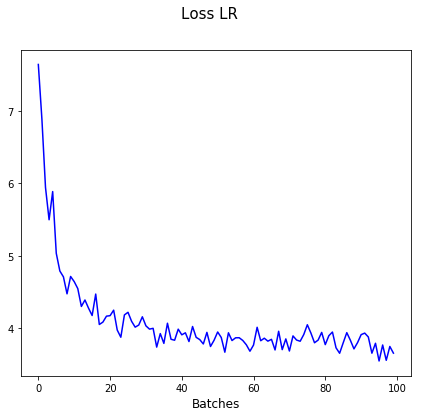

In [8]:
fig = plt.figure(figsize=(7,6))    
fig.suptitle("Loss LR",fontsize=15)
plt.plot(range(len(los)),los, 'b-')
plt.xlabel("Batches", fontsize=12)
plt.show()